In [1]:
from tqdm import tqdm
import os
import logging
from pathlib import Path
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.animation as animation
from PIL import Image
import re
import tifffile
import json
import time
import hashlib
from os.path import exists
import h5py

In [3]:
DATA_ROOT_DIR = '/proj/case/2025-06-05'
ALL_DIRS = os.listdir(DATA_ROOT_DIR)
EUCLID_DIRS = []
CASE_DIRS = []

CASE_NUM_FILES = 22500
TOTAL_FRAMES = 450
IMG_SIZE = (2048, 2048)
DETECTOR_SIZE = (450, 2048, 2048)

#### Grab all directories

In [4]:
!ls '/proj/case/2025-06-05'

'$RECYCLE.BIN'	    18274_Euclid_SCA   FPM_102_101   FPM_EM3_EM6_post_vibe
 18220_Euclid_SCA   18275_Euclid_SCA   FPM_102_105   FPM_EM3_EM6_pre_vibe
 18248_Euclid_SCA   18282_Euclid_SCA   FPM_104_103  'System Volume Information'
 18266_Euclid_SCA   18283_Euclid_SCA   FPM_EM1_EM2


In [5]:
for dir in ALL_DIRS:
    if 'Euclid' in dir:
        EUCLID_DIRS.append(dir)
    elif 'FPM' in dir:
        CASE_DIRS.append(dir)

print(f'Euclid test data directories: {EUCLID_DIRS}\n')
print(f'Case test data directories: {CASE_DIRS}')

Euclid test data directories: ['18220_Euclid_SCA', '18248_Euclid_SCA', '18266_Euclid_SCA', '18274_Euclid_SCA', '18275_Euclid_SCA', '18282_Euclid_SCA', '18283_Euclid_SCA']

Case test data directories: ['FPM_102_101', 'FPM_102_105', 'FPM_104_103', 'FPM_EM1_EM2', 'FPM_EM3_EM6_post_vibe', 'FPM_EM3_EM6_pre_vibe']


#### Preprocess the Data

In [ ]:
class TrainingData:
    """

    """
    def __init__(self, root_dir = 'training_set'):
        """

        """
        # Setup logging
        logging.basicConfig(level = logging.INFO)
        self.logger = logging.getLogger(__name__)

        # Create directories
        self.root_dir = Path(root_dir)
        self.create_directory()

        # Cache registry
        self.registry_file =f'{self.root_dir}/processing_registry.json'
        self.registry = self.load_registry()

        # Processing paramaters
        self.patch_sizes = [512, 256, 128] # ! NOTE hyperparamter, adjust me
        self.overlap_ratio = 0.25 # ! NOTE hyperparameter, adjust me


    def create_directory(self):
        """
            * basically creates a directory structure for preprocessed h5py storage
        """
        # Make the training set directory
        self.root_dir.mkdir(parents=True, exist_ok=True)

        # Make difference array directory
        (self.root_dir / 'raw_differences').mkdir(parents=True, exist_ok=True)

        # Make patches directory
        (self.root_dir / 'patches').mkdir(parents=True, exist_ok=True)

        # Make temporal analysis directory
        (self.root_dir / 'temporal_analysis').mkdir(parents=True, exist_ok=True)

        # Make metadata directory
        (self.root_dir / 'metadata').mkdir(parents=True, exist_ok=True)

        self.logger.info(f'Created directory structure at {self.root_dir}')

    
    def load_registry(self):
        """
            * load processing registry or create a new one
        """
        if exists(self.registry_file):
            with open(self.registry_file, 'r') as f:
                return json.load(f)
        return {'processed_files': {}, 'processed_exposures': {}, 'last_updated': time.time()}
        
    
    def save_registry(self):
        """
            * save processing registry
        """
        # Update timestamp
        self.registry['last_updated'] = time.time()
        
        # Save the registry
        with open(self.registry_file, 'w') as f:
            json.dump(self.registry, f, indent=2)
        
        # Hash the saved file
        hasher = hashlib.md5()
        with open(self.registry_file, 'rb') as f:  # Read mode for hashing
            for chunk in iter(lambda: f.read(4096), b''):
                hasher.update(chunk)
        
        registry_hash = hasher.hexdigest()
        self.logger.info(f"Registry saved with hash: {registry_hash}")

        return registry_hash
    

    def get_exposure_hash(self, file_paths):
        """
            * generate a hash for a group of files (expsosure)
            * return the hash
        """
        hasher = hashlib.md5()

        # Iterate through every frame
        for file_path in sorted(file_paths):
            # Update the hasher with the encoded current file
            hasher.update(file_path.encode())

            # Check if the file path exists in the root
            if exists(file_path):
                hasher.update(str(os.path.getmtime(file_path)).encode())
            
        return hasher.hexdigest()
    

    def is_exposure_cached(self, exposure_id, file_paths):
        """
            * checks if the current exposure has been cached yet
        """
        if exposure_id not in self.registry['processed_exposures']:
            return False
        
        # Make sure the file has not been changed
        curr_hash = self.get_exposure_hash(file_paths)
        cached_hash = self.registry['processed_exposures'][exposure_id]['exposure_hash']

        return curr_hash == cached_hash

    
    def _grab_filenames(self, path):
        """
            * basically grab all filenames for the current path
        """
        try:
            entries = os.listdir(path)
            filenames = [entry for entry in entries if os.path.isfile(os.path.join(path, entry))]
        
        except FileNotFoundError as e:
            self.logger.error('Folder not found at {path} : {e}')
            return None
        
        return filenames
    
    @staticmethod
    def _subtract_ref_pixels(frame):
        """
            * perform ref pixel subtraction as documented in paper
                Reference Pixel Subtraction
                Method for EUCLID SCS Noise
                Specification
                Bogna Kubik
        """
        # Make sure shape is 2048 x 2048
        if frame.shape != (2048, 2048):
            raise ValueError(f'Invalid frame shape of {frame.shape}, must be (2048, 2048)')
        
        corrected_frame = frame.copy().astype(np.float64)

        # Optimal window side via paper
        x_opt = 64
        y_opt = 4

        # Reference pixel regions
        up_ref = frame[0:4, :] # Top 4 rows
        down_ref = frame[2044:2048, :] # Bottom 4 rows
        left_ref = frame[:, 0:4] # Left 4 cols
        right_ref = frame[:, 2044:2048]

        # Process each of the 32 channels
        for ch in range(32):
            # Skip left ref pixels
            if ch == 0:
                col_start, col_end = 4, 64
            
            # Skip right ref pixels
            elif ch == 31:
                col_start, col_end = ch * 64, 2044  # Fixed: clearer intent

            # Inner channels
            else:
                col_start, col_end = ch * 64, (ch + 1) * 64

            # Up/down correction w/ extract channel specific ref pixels 
            for col in range(col_end - col_start):
                global_col = col_start + col

                # Sliding window for up/down
                window_start = max(0, global_col -  x_opt)
                window_end = min(2048, global_col + x_opt + 1)

                # Average the up and down ref pixels
                up_avg = np.mean(up_ref[:, window_start:window_end])
                down_avg = np.mean(down_ref[:, window_start:window_end])

                # Interpolate correction
                slope = (up_avg - down_avg) / 2044

                # Apply correction to each row in the column, skipping refs
                for row in range(4, 2044):
                    ref_correction = down_avg + (row - 1.5) * slope
                    corrected_frame[row, global_col] -= ref_correction

        # Correct left ref pixel
        left_ref_corrected = left_ref.copy()
        right_ref_corrected = right_ref.copy()

        # Subtract the up/down correction from the left/right pixels
        up_avg_full = np.mean(up_ref)
        down_avg_full = np.mean(down_ref)
        slope_full = (up_avg_full - down_avg_full) / 2044

        # Fixed: Correct the left/right ref pixels with proper loop
        for row in range(4, 2044):
            ref_correction = down_avg_full + (row - 1.5) * slope_full
            left_ref_corrected[row, :] -= ref_correction
            right_ref_corrected[row, :] -= ref_correction

        # Apply the correction using sliding window
        for row in range(4, 2044):
            # Sliding window for left/right
            window_start = max(4, row - y_opt)
            window_end = min(2044, row + y_opt + 1)

            # Fixed: Average corrected left/right pixels (syntax error)
            left_avg = np.mean(left_ref_corrected[window_start:window_end, :])
            right_avg = np.mean(right_ref_corrected[window_start:window_end, :])  # Fixed the dot
            lr_correction = (left_avg + right_avg) / 2

            corrected_frame[row, 4:2044] -= lr_correction

        return corrected_frame
    
    
    def _compute_difference_fits(self, file_path):
        """
            * subtract frame 0 from the current fits file
        """
        dif_stack = []
        time_stack = []

        # Open the current fits file
        with fits.open(file_path) as hdul:
            # Grab frame 0
            frame_0 = hdul[1].data.astype(np.float64)

            # Subtract reference pixels
            frame_0 = self._subtract_ref_pixels(frame_0)

            # Iterate through all frames, skipping the first (2 - 450)
            for i in tqdm(range(2, TOTAL_FRAMES + 1), 
                          desc = 'Frame difference calculation for EUCLID'):
                # Grab the current frame
                curr_frame = hdul[i].data.astype(np.float64)
                curr_frame = self._subtract_ref_pixels(curr_frame)

                # Subtract from 0
                dif = np.abs(curr_frame - frame_0)
                dif_stack.append(dif)
                time_stack.append(i - 1) 

                # if i ==5:
                #     break # FIXME GET RID OF BREAK JUST FOR TESTING

        return {
            'differences': np.array(dif_stack),
            'frame_times': np.array(time_stack),
            'reference_frame': frame_0,
            'total_frames': len(dif_stack) 
        }
    
    
    def _compute_difference_tif(self, detector_frames):
        """
            * subtract frame 0 from the current fits file
            * split the 2 detectors
        """
        detector_frames = np.array(detector_frames)
        dif_stack = []
        time_stack = []

        # Grab the 0th frame for the current detector
        frame_0 = detector_frames[0].astype(np.float64)

        # Subtract the reference pixels
        frame_0 = self._subtract_ref_pixels(frame_0)

        # Iterate through all frames
        for i, frame in tqdm(enumerate(detector_frames[1:], start = 1),
                             desc = 'Frame difference calculation for CASE'):
            curr_frame = frame.astype(np.float64)
            curr_frame = self._subtract_ref_pixels(curr_frame)

            # Perform the frame difference
            dif = np.abs(curr_frame - frame_0)
            dif_stack.append(dif)
            time_stack.append(i)

        return {
            'differences': np.array(dif_stack),
            'frame_times': np.array(time_stack),
            'reference_frame': frame_0,
            'total_frames': len(dif_stack)
        }
    
    def _analyze_temporal_patterns(self, diff_stack, threshold = 5): 
        """
            * analyze temporal patterns in difference images for snowball/cosmic ray detection
        """
        num_frames, height, width = diff_stack.shape
        
        # Initialize temporal maps
        first_appearance = np.full((height, width), -1, dtype = np.int32)
        persistence_count = np.zeros((height, width), dtype = np.int32)
        max_intensity = np.zeros((height, width), dtype = np.float32)
        
        # Track temporal evolution
        temporal_evolution = []
        
        # Iterate through every frame
        for frame_idx in range(num_frames):
            diff_frame = diff_stack[frame_idx]
            
            # Find anomalies above threshold
            anomaly_mask = diff_frame > threshold
            
            # Update first appearance
            new_anomalies = anomaly_mask & (first_appearance == -1)
            first_appearance[new_anomalies] = frame_idx
            
            # Update persistence count
            persistence_count[anomaly_mask] += 1
            
            # Update max intensity
            max_intensity = np.maximum(max_intensity, diff_frame)
            
            # Track frame-level statistics
            temporal_evolution.append({
                'frame': frame_idx,
                'n_anomalies': np.sum(anomaly_mask),
                'mean_intensity': np.mean(diff_frame[anomaly_mask]) if np.any(anomaly_mask) else 0,
                'max_intensity': np.max(diff_frame)
            })
        
        return {
            'first_appearance': first_appearance,
            'persistence_count': persistence_count,
            'max_intensity': max_intensity,
            'temporal_evolution': temporal_evolution,
            'threshold_used': threshold
        }
    

    def _extract_patches(self, diff_stack, patch_size):
        """
            * extract overlapping patches from difference images for ViT-VAE training
        """
        num_frames, height, width = diff_stack.shape
        overlap = int(patch_size * self.overlap_ratio)
        stride = patch_size - overlap
        
        patches = []
        positions = []
        frame_indices = []
        anomaly_scores = []
        
        # Calculate patch grid
        num_patches_height = (height - patch_size) // stride + 1
        num_patches_width = (width - patch_size) // stride + 1
        
        self.logger.info(
            f'Extracting {num_patches_height}x{num_patches_width} patches of size {patch_size}x{patch_size}')
        
        # Iterate through every frame
        for frame_idx in range(num_frames):
            diff_frame = diff_stack[frame_idx]
            
            # Iterate through each pixel in that current patch
            for i in range(0, height - patch_size + 1, stride):
                for j in range(0, width - patch_size + 1, stride):
                    patch = diff_frame[i:i+patch_size, j:j+patch_size]
                    
                    # Calculate anomaly score for this patch
                    anomaly_score = np.max(patch)  # Simple max intensity
                    
                    patches.append(patch)
                    positions.append((i, j))
                    frame_indices.append(frame_idx)
                    anomaly_scores.append(anomaly_score)
        
        return {
            'patches': np.array(patches),
            'positions': np.array(positions),
            'frame_indices': np.array(frame_indices),
            'anomaly_scores': np.array(anomaly_scores),
            'patch_size': patch_size,
            'overlap': overlap,
            'stride': stride,
            'grid_shape': (num_patches_height, num_patches_width)
        }
    

    def _save_processed_exposure(self, exposure_id, diff_data, temporal_data, patches_data, detector_info):
        """
            * save all processed data for an exposure to h5 files
        """
        # Save difference data
        diff_file = self.root_dir / 'raw_differences' / f'{exposure_id}_differences.h5'
        with h5py.File(diff_file, 'w') as f:
            f.create_dataset('differences', data = diff_data['differences'], 
                           compression = 'gzip', compression_opts = 9)
            f.create_dataset('frame_times', data = diff_data['frame_times'])
            f.create_dataset('reference_frame', data = diff_data['reference_frame'],
                           compression = 'gzip', compression_opts=9)
            f.attrs['total_frames'] = diff_data['total_frames']
            f.attrs['exposure_id'] = exposure_id
            
            # Save detector info
            for key, value in detector_info.items():
                f.attrs[key] = value
        
        # Save temporal analysis
        temporal_file = self.root_dir / 'temporal_analysis' / f'{exposure_id}_temporal.h5'
        with h5py.File(temporal_file, 'w') as f:
            f.create_dataset('first_appearance', data = temporal_data['first_appearance'])
            f.create_dataset('persistence_count', data = temporal_data['persistence_count'])
            f.create_dataset('max_intensity', data = temporal_data['max_intensity'])
            f.attrs['threshold_used'] = temporal_data['threshold_used']
            
            # Save temporal evolution
            evolution_dtype = [('frame', 'i4'), ('n_anomalies', 'i4'), 
                             ('mean_intensity', 'f4'), ('max_intensity', 'f4')]
            evolution_array = np.array([(e['frame'], e['n_anomalies'], 
                                       e['mean_intensity'], e['max_intensity']) 
                                      for e in temporal_data['temporal_evolution']], 
                                     dtype = evolution_dtype)
            f.create_dataset('temporal_evolution', data = evolution_array)
        
        # Save patches at different scales
        for patch_key, patch_data in patches_data.items():
            patch_size = patch_data['patch_size']
            patch_file = self.root_dir / 'patches' / f'{exposure_id}_patches_{patch_size}.h5'
            
            with h5py.File(patch_file, 'w') as f:
                f.create_dataset('patches', data = patch_data['patches'], 
                               compression = 'gzip', compression_opts = 9)
                f.create_dataset('positions', data = patch_data['positions'])
                f.create_dataset('frame_indices', data = patch_data['frame_indices'])
                f.create_dataset('anomaly_scores', data = patch_data['anomaly_scores'])
                f.attrs['patch_size'] = patch_data['patch_size']
                f.attrs['overlap'] = patch_data['overlap']
                f.attrs['stride'] = patch_data['stride']
                f.attrs['grid_shape'] = patch_data['grid_shape']
        
        # Save metadata
        metadata = {
            'exposure_id': exposure_id,
            'processing_time': time.time(),
            'patch_sizes': list(patches_data.keys()),
            'detector_info': detector_info,
            'total_frames': diff_data['total_frames']
        }
        
        metadata_file = self.root_dir / 'metadata' / f'{exposure_id}_metadata.json'
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)


    def _process_single_exposure(self, exposure_id, diff_data, dataset_type, detector_info):
        """
            * complete preprocessing pipeline for a single exposure
        """
        try:
            self.logger.info(f'Processing exposure {exposure_id}...')
            
            # Step 1: Temporal analysis
            temporal_data = self._analyze_temporal_patterns(diff_data['differences'])
            
            # Step 2: Extract patches at multiple scales
            patches_data = {}
            for patch_size in self.patch_sizes:
                patches_data[f'patches_{patch_size}'] = self._extract_patches(
                    diff_data['differences'], patch_size
                )
            
            # Step 3: Save everything
            self._save_processed_exposure(exposure_id, diff_data, temporal_data, 
                                        patches_data, detector_info)
            
            # Step 4: Update registry
            self.registry['processed_exposures'][exposure_id] = {
                'exposure_hash': detector_info.get('exposure_hash', ''),
                'processed_time': time.time(),
                'dataset_type': dataset_type,
                'detector_info': detector_info
            }
            self.save_registry()
            
            self.logger.info(f'Successfully processed exposure {exposure_id}')
            return True
            
        except Exception as e:
            self.logger.error(f'Error processing exposure {exposure_id}: {e}')
            return False

    
    def preprocess(self, dataset_name):
        """
            * main preprocessing dispather
        """
        dataset_name = dataset_name.upper()
        
        if dataset_name == 'EUCLID':
            return self._euclid_preprocess()
        elif dataset_name == 'CASE':
            return self._case_preprocess()
        else:
            raise ValueError(f'Invalid dataset name of {dataset_name}, must be EUCLID or CASE')
      

    def _euclid_preprocess(self):
        """
            * preprocessing for euclid testing data
        """ 
        processed_exposures = []

        # Process all Euclid directories
        for dir_name in EUCLID_DIRS:
            path = f'{DATA_ROOT_DIR}/{dir_name}'
            filenames = self._grab_filenames(path)

            # Make sure there are actual filenames
            if filenames is None:
                self.logger.error(
                    '"filenames" array is empty, please make sure that "EUCLID_DIRS" has been loaded')
                return None
            
            # Sort the filenames by exposure
            sorted_filenames = sorted(filenames, key = lambda x: int(re.search(r'E(\d+)', x).group(1)))

            # Logging stuff for caching progress
            processed_count = 0
            cached_count = 0
            total_files = len(sorted_filenames)

            self.logger.info(f'Starting {dir_name}: {total_files} FITS files to process')

            for filename in sorted_filenames:
                # Make sure that it is a fits file
                if filename.endswith('.fits'):
                    curr_path = f'{path}/{filename}'
                    exposure_id = f'euclid_{dir_name}_{Path(filename).stem}'

                    # Check if already cached
                    if self.is_exposure_cached(exposure_id, [curr_path]):
                        cached_count += 1
                        self.logger.debug(f'Exposure {exposure_id} already cached, skipping ...')
                        continue

                    # Calculate the difference in frames
                    dif_stack = self._compute_difference_fits(curr_path)

                    # Detector info
                    detector_info = {
                        'dataset_type': 'EUCLID',
                        'directory': dir_name,
                        'filename': filename,
                        'file_path': curr_path,
                        'detector_id': 'single',
                        'exposure_hash': self.get_exposure_hash([curr_path])
                    }

                    # Process the exposure
                    if self._process_single_exposure(exposure_id, dif_stack, 'EUCLID', detector_info):
                        processed_exposures.append(exposure_id)
                        processed_count += 1

                    # Do processed exposure logging
                    if processed_count % 5 == 0 and processed_count > 0:
                        self.logger.info(
                            f'Progress {dir_name}: {processed_count} processed, '
                            f'{cached_count} cached, {processed_count + cached_count}/{total_files} total'
                        )
                        self.save_registry()

                    break # DELETE ME AT SOMEPOINT JUST FOR TESTING !TEST FIXME 

            # Progress printing
            total_checked = processed_count + cached_count
            self.logger.info(
                f'Completed {dir_name}: {processed_count} newly processed, '
                f'{cached_count} already cached, {total_checked}/{total_files} total files'
            )
                    
            # Save registry after each directory
            self.save_registry() if processed_count > 0 else None

            break # DELETE ME AT SOME POINT JUST FOR TESTING FIXME

        self.logger.info(f'Processed {len(processed_exposures)} Euclid exposures')

        return processed_exposures

    
    def _case_preprocess(self):
        """
            * preprocessing for case test
            * has two detectors and 8 extra cols / detector
        """
        processed_exposures = []

        # Process all CASE directories
        for dir_name in CASE_DIRS:
            # Make sure to grab files in the nested directory
            path = f'{DATA_ROOT_DIR}/{dir_name}'
            nested_dirs = os.listdir(path)
            
            # Check if there are nested directories
            if not nested_dirs:
                self.logger.error(f'"nested_dirs" array is empty, please make sure CASE_DIRS has been loaded ...')
                return None

            path = f'{path}/{nested_dirs[0]}'
            filenames = self._grab_filenames(path)

            if filenames is None:
                self.logger.error('"filenames" array is empty, please make sure CASE_DIRS has been loaded ...')
                return None

            # Sort filenames in ascending order
            sorted_filenames = sorted(filenames, key = lambda x: int(re.search(r'N(\d+)', x).group(1)))

            # Logging stuff for caching progress
            processed_count = 0
            cached_count = 0
            total_exposures = len(filenames) // TOTAL_FRAMES

            self.logger.info(f'Found {len(sorted_filenames)} files in {dir_name}')

            # Group every 450th file together (1-450, 451-900, etc)
            for exposure_idx, i in enumerate(range(0, len(sorted_filenames), TOTAL_FRAMES)):
                group = sorted_filenames[i : i + TOTAL_FRAMES]

                # Make sure that each group has 450 files in it
                if len(group) != TOTAL_FRAMES:
                    self.logger.error(
                        f'Incomplete exposure group: {len(group)} files instead of {TOTAL_FRAMES}')
                    return None
                
                # Create exposure id
                exposure_id = f'case_{dir_name}_exp{exposure_idx:03d}'

                # Create filepaths for the current exposure
                group_paths = [f'{path}/{filename}' for filename in group]

                # Check if both detectors are already cached
                d1_cached = self.is_exposure_cached(f'{exposure_id}_det1', group_paths)
                d2_cached = self.is_exposure_cached(f'{exposure_id}_det2', group_paths)

                if d1_cached and d2_cached:
                    cached_count += 1
                    self.logger.debug(f'Both detectors for {exposure_id} already cached, skipping...')
                    continue

                d1_frame_stack = []
                d2_frame_stack = []
                
                # Process each frame in the exposure
                for curr_file in group:
                    curr_path = f'{path}/{curr_file}'

                    # Grab the tif file for that path
                    tif_data = tifffile.imread(curr_path)

                    # Split the data in half
                    split_index = tif_data.shape[1] // 2

                    d1 = tif_data[:, :split_index]
                    d2 = tif_data[:, split_index:]

                    # Remove the extra 8 columns
                    d1 = d1[:, 8:-8]
                    d2 = d2[:, 8:-8]

                    # Verify the shape of the detector data
                    if d1.shape != IMG_SIZE or d2.shape != IMG_SIZE:
                        self.logger.error(f'Invalid detector shapes: {d1.shape}, {d2.shape}')
                        return None
                    
                    # Calculate the difference for both detectors 
                    d1_frame_stack.append(d1)
                    d2_frame_stack.append(d2)

                # Convert to numpy arrays
                d1_frame_stack = np.array(d1_frame_stack)
                d2_frame_stack = np.array(d2_frame_stack)

                # Verify file shape
                if d1_frame_stack.shape != DETECTOR_SIZE or d2_frame_stack.shape != DETECTOR_SIZE:  # Added .shape
                    self.logger.error(f'Invalid detector stack shapes: {d1_frame_stack.shape}, {d2_frame_stack.shape}')
                    return None
                
                # Only process detectors that aren't cached
                detectors_to_process = []
                if not d1_cached:
                    detectors_to_process.append((1, d1_frame_stack))
                if not d2_cached:
                    detectors_to_process.append((2, d2_frame_stack))

                # Process both detectors
                detectors_processed = []
                for detector_idx, frame_stack in detectors_to_process:
                    # Create detector exposure id
                    detector_exposure_id = f'{exposure_id}_det{detector_idx}'
                
                    # Calculate the frame difference
                    diff_stack = self._compute_difference_tif(frame_stack)

                    # Detector info
                    detector_info = {
                        'dataset_type': 'CASE',
                        'directory': dir_name,
                        'exposure_index': exposure_idx,
                        'detector_id': f'detector_{detector_idx}',
                        'total_files': len(group),
                        'file_range': f'{group[0]} to {group[-1]}',
                        'exposure_hash': self.get_exposure_hash(group_paths)
                    }
                    
                    # Process the detector exposure
                    if self._process_single_exposure(detector_exposure_id, diff_stack, 'CASE', detector_info):
                        processed_exposures.append(detector_exposure_id)
                        detectors_processed.append(detector_idx)

                # Count this exposure as processed if any detector was processed
                if len(detectors_processed) > 0:
                    processed_count += 1

                # Progress printing
                total_checked = processed_count + cached_count
                if total_checked % 5 == 0 and total_checked > 0:
                    self.logger.info(
                        f'Progress {dir_name}: {processed_count} processed, '
                        f'{cached_count} cached, {total_checked}/{total_exposures} exposures'
                    )
                    self.save_registry()

                # BREAK FOR NOW AFTER FIRST EXP TEST
                break

            # Final summary for this directory
            total_checked = processed_count + cached_count
            self.logger.info(
                f'Completed {dir_name}: {processed_count} newly processed, '
                f'{cached_count} already cached, {total_checked}/{total_exposures} total exposures'
            )

        self.logger.info(f'Processed {len(processed_exposures)} CASE detector exposures')
        
        return processed_exposures
    

    def load_training_dataset(self, dataset_type, patch_size, min_anomaly_score, detector_id):
        """
            * load processed data for training
        """
        all_patches = []
        all_positions = []
        all_frame_indices = []
        all_anomaly_scores = []
        all_exposure_ids = []
        
        # Filter exposures by dataset type and detector
        exposures_to_load = []
        for exposure_id, info in self.registry['processed_exposures'].items():
            if dataset_type is None or info.get('dataset_type') == dataset_type:
                if detector_id is None or info['detector_info'].get('detector_id') == detector_id:
                    exposures_to_load.append(exposure_id)
        
        self.logger.info(f'Loading {len(exposures_to_load)} exposures for training...')
        
        # Iterate through all exposure ids
        for exposure_id in tqdm(exposures_to_load, desc='Loading training data'):
            patch_file = self.root_dir / 'patches' / f'{exposure_id}_patches_{patch_size}.h5'
            
            # Check to see if the current file exists
            if exists(patch_file):
                with h5py.File(patch_file, 'r') as f:
                    patches = f['patches'][:]
                    positions = f['positions'][:]
                    frame_indices = f['frame_indices'][:]
                    anomaly_scores = f['anomaly_scores'][:]
                    
                    # Filter by anomaly score
                    mask = anomaly_scores >= min_anomaly_score
                    
                    all_patches.append(patches[mask])
                    all_positions.append(positions[mask])
                    all_frame_indices.append(frame_indices[mask])
                    all_anomaly_scores.append(anomaly_scores[mask])
                    all_exposure_ids.extend([exposure_id] * np.sum(mask))
        
        # Combine all data
        combined_data = {
            'patches': np.concatenate(all_patches) if all_patches else np.array([]),
            'positions': np.concatenate(all_positions) if all_positions else np.array([]),
            'frame_indices': np.concatenate(all_frame_indices) if all_frame_indices else np.array([]),
            'anomaly_scores': np.concatenate(all_anomaly_scores) if all_anomaly_scores else np.array([]),
            'exposure_ids': all_exposure_ids,
            'patch_size': patch_size,
            'dataset_type': dataset_type,
            'detector_id': detector_id,
            'total_patches': len(all_exposure_ids)
        }

        self.logger.info(f'Loaded {combined_data['total_patches']} patches for training')
        return combined_data
        

    def get_statistics(self):
        """
            * get statistics about processed data
        """
        stats = {
            'total_exposures': len(self.registry['processed_exposures']),
            'euclid_exposures': 0,
            'case_exposures': 0,
            'case_detector_1': 0,
            'case_detector_2': 0,
            'patch_sizes_available': set(),
            'processing_times': []
        }
        
        for exposure_id, info in self.registry['processed_exposures'].items():
            dataset_type = info.get('dataset_type', 'unknown')
            detector_id = info['detector_info'].get('detector_id', 'unknown')
            
            if dataset_type == 'EUCLID':
                stats['euclid_exposures'] += 1
            elif dataset_type == 'CASE':
                stats['case_exposures'] += 1
                if detector_id == 'detector_1':
                    stats['case_detector_1'] += 1
                elif detector_id == 'detector_2':
                    stats['case_detector_2'] += 1
            
            stats['processing_times'].append(info.get('processed_time', 0))
            
            # Check available patch sizes
            for patch_file in (self.root_dir / 'patches').glob(f'{exposure_id}_patches_*.h5'):
                size = int(patch_file.stem.split('_')[-1])
                stats['patch_sizes_available'].add(size)
        
        stats['patch_sizes_available'] = sorted(list(stats['patch_sizes_available']))
        return stats


    def load():
        print('ay')



### Training

#### Testing

<span style="color:red">DO NOT RUN CELLS UNDER ME</span>

In [7]:
# Initialize training data processor
trainer = TrainingData(root_dir='training_set')

INFO:__main__:Created directory structure at training_set


Euclid Exposure Testing

In [8]:
# Process Euclid data
print("Processing Euclid data...")
euclid_exposures = trainer.preprocess('EUCLID')

INFO:__main__:Starting 18220_Euclid_SCA: 100 FITS files to process


Processing Euclid data...


Frame difference calculation for EUCLID:   4%|▍         | 18/448 [00:40<16:13,  2.26s/it]


KeyboardInterrupt: 

In [ ]:
euclid_exposures

['euclid_18220_Euclid_SCA_ap30_100k_0p8m0p3_fullnoi_E001_18220']

In [ ]:
exposure_id = euclid_exposures[0] # only do the first one

diff_file = trainer.root_dir / 'raw_differences' / f'{exposure_id}_differences.h5'

with h5py.File(diff_file, 'r') as f:
    differences = f['differences'][:]
    reference_frame = f['reference_frame'][:]
    frame_times = f['frame_times'][:]
    
    # Get info
    total_frames = f.attrs['total_frames']

differences

array([[[154., 120., 116., ..., 101., 115., 125.],
        [ 42.,  48.,  40., ...,  39.,  46.,  54.],
        [ 28.,  22.,  12., ...,  21.,  24.,  35.],
        ...,
        [ 12.,   7.,   3., ...,   3.,   5.,   3.],
        [ 12.,  12.,   8., ...,   6.,   1.,   7.],
        [  6.,   5.,   8., ...,   2.,   1.,   6.]],

       [[150., 124., 112., ..., 100., 111., 132.],
        [ 40.,  46.,  36., ...,  53.,  51.,  37.],
        [ 30.,  30.,  32., ...,  26.,  18.,  26.],
        ...,
        [ 10.,   1.,  10., ...,   1.,   2.,   4.],
        [ 16.,  12.,   8., ...,  12.,   1.,   2.],
        [  7.,   7.,   0., ...,   9.,  10.,  11.]],

       [[148., 130., 118., ...,  99., 110., 132.],
        [ 36.,  40.,  40., ...,  58.,  50.,  52.],
        [ 32.,  37.,  22., ...,  31.,  19.,  26.],
        ...,
        [  1.,   5.,   6., ...,   7.,   1.,   8.],
        [  2.,   2.,   0., ...,  11.,   8.,   4.],
        [ 14.,   1.,   8., ...,   6.,  10.,   2.]],

       [[146., 128., 106., ...,  95.,

In [ ]:
len(differences)

4

!!!!! BELLA NOTE ON MONDAY DO A PLOT OF THE AVG DIF FOR EACH FRAME OR LIKE A HIST AND THE STD TO SEE WHIHC HAVE VERTICAL LINES BECASUE ITS NOT ALL OF THEM TYSM

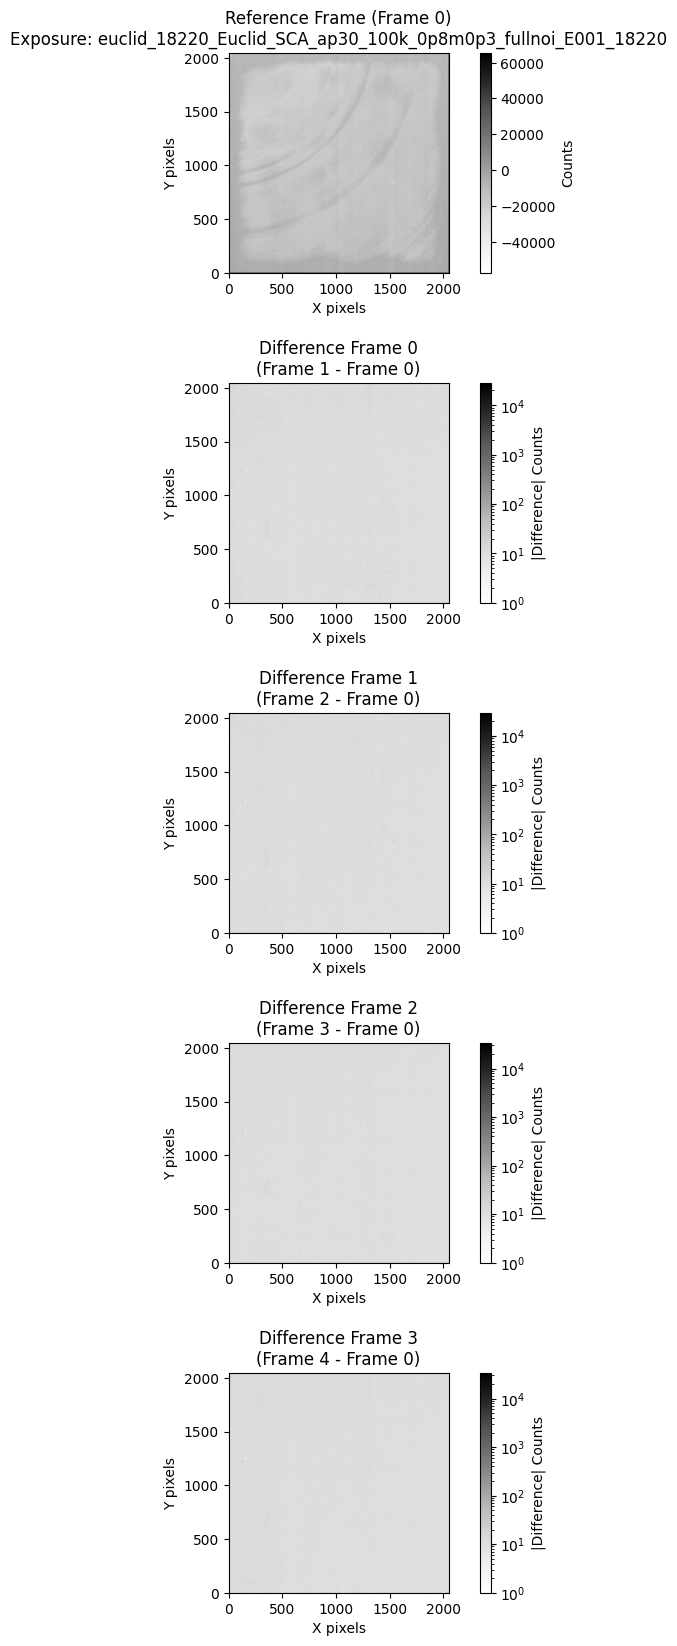

In [71]:
# Generate frame indexes
frame_idxs = np.arange(0, len(differences))

# Create subplots (1 for reference + len(differences))
fig, axs = plt.subplots(1 + len(differences), 1, figsize=(8, 4 * (1 + len(differences))))
plt.subplots_adjust(hspace=0.5)

# Plot reference frame
im1 = axs[0].imshow(reference_frame, cmap='Greys', origin='lower')
axs[0].set_title(f'Reference Frame (Frame 0)\nExposure: {exposure_id}')
axs[0].set_xlabel('X pixels')
axs[0].set_ylabel('Y pixels')
plt.colorbar(im1, ax=axs[0], label='Counts')

# Plot each difference frame in its own subplot
for i, frame_idx in enumerate(frame_idxs):
    diff_frame = differences[frame_idx] + 1  # Add 1 to avoid log(0)
    ax = axs[i + 1]  # Start from axs[1]
    im2 = ax.imshow(diff_frame, cmap='Greys', origin='lower',
                    norm=LogNorm(vmin=1, vmax=diff_frame.max()))
    ax.set_title(f'Difference Frame {frame_idx}\n(Frame {frame_times[frame_idx]} - Frame 0)')
    ax.set_xlabel('X pixels')
    ax.set_ylabel('Y pixels')
    plt.colorbar(im2, ax=ax, label='|Difference| Counts')

plt.show()


In [ ]:
training = TrainingData

# frame_difs, last_frame = training._euclid_preprocess(training)
frame_difs = training._euclid_preprocess(training)

  0%|          | 0/448 [00:02<?, ?it/s]


In [ ]:
frame_difs

array([[[164.,  82., 126., ..., 122.,  97., 137.],
        [ 48.,  52.,  50., ...,  62.,  62.,  46.],
        [ 16.,  36.,  43., ...,  36.,  28.,  36.],
        ...,
        [ 14.,  12.,   1., ...,   2.,  10.,   6.],
        [ 17.,   6.,  30., ...,  22.,   3.,  19.],
        [ 32.,   6.,  16., ...,   1.,   8.,  32.]]], shape=(1, 2048, 2048))

In [22]:
training = TrainingData

# frame_difs, last_frame = training._euclid_preprocess(training)
d1_frame0, detector_1_difs, d2_frame_0, detector_2_difs = training._case_preprocess(training)

<tifffile.TiffTag 305 @16908430> coercing invalid ASCII to bytes, due to UnicodeDecodeError('charmap', b'Matrox Imaging Library [10.00]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x
<tifffile.TiffTag 305 @16908430> coercing invalid ASCII to bytes, due to UnicodeDecodeError('charmap', b'Matrox Imaging Library [10.00]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x
<tifffile.TiffTag 305 @16908430> coercing invalid ASCII to bytes, due to UnicodeDecodeError('charmap', b'Matrox Imaging Library [10.00]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x
<tifffile.TiffTag 305 @16908430> coercing invalid ASCII to bytes, due to UnicodeDecodeError('charmap', b'Matrox Imaging Library [10.00]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x
<tifffile.TiffTag 305 @16908430> coercing invalid ASCII to bytes, due to UnicodeDecodeError('charmap', b'Matrox Imaging Library [10.00]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

(450, 2048, 2048) (450, 2048, 2048)


Frame difference calculation for CASE: 0it [00:02, ?it/s]
Frame difference calculation for CASE: 0it [00:01, ?it/s]


#### Image Testing

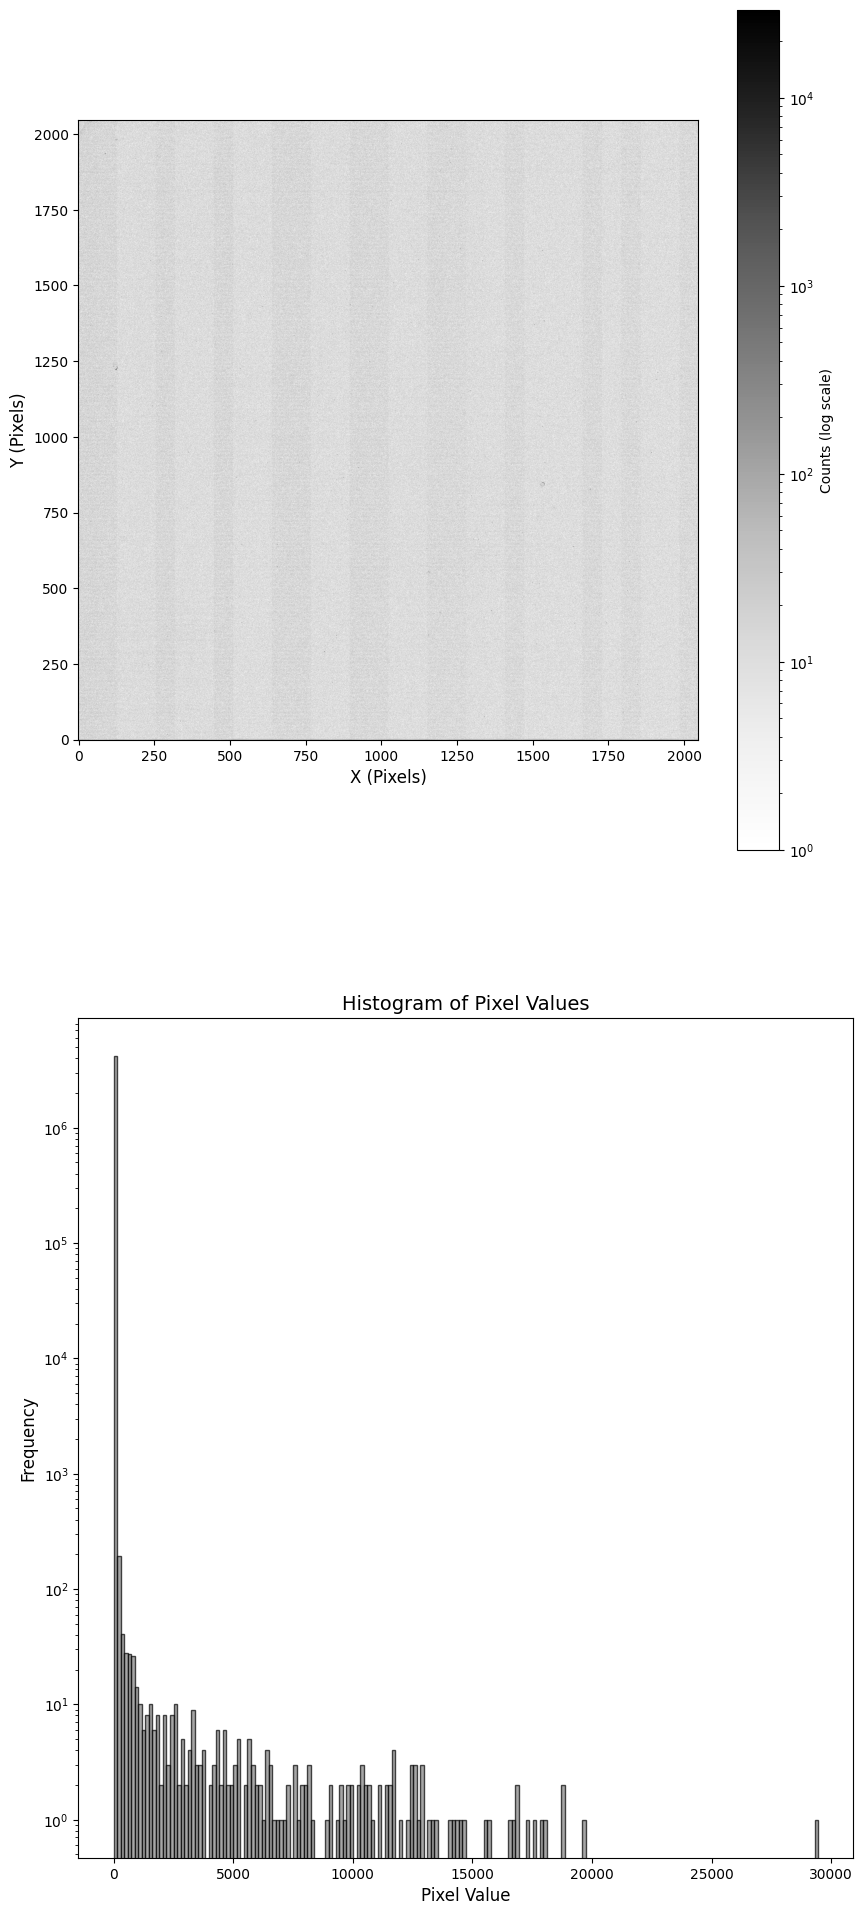

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (10,24))
    

frame_dif = frame_difs[0]

# Plot frame with log scale - add small value to avoid log(0)
frame_dif_log = frame_dif + 1  # Add 1 to avoid log(0)
im = axs[0].imshow(frame_dif_log, cmap='Greys', origin='lower', 
                    norm=LogNorm(vmin=1, vmax=frame_dif_log.max()))
axs[0].set_xlabel('X (Pixels)', size=12)
axs[0].set_ylabel('Y (Pixels)', size=12)
plt.colorbar(im, ax=axs[0], label='Counts (log scale)')

# Plot histogram of counts (already log scale)
axs[1].hist(frame_dif.flatten(), bins=200, alpha=0.7, edgecolor='black', color='grey')
axs[1].set_xlabel('Pixel Value', size=12)
axs[1].set_ylabel('Frequency', size=12)
axs[1].set_title('Histogram of Pixel Values', size=14)
axs[1].set_yscale('log')

plt.show()

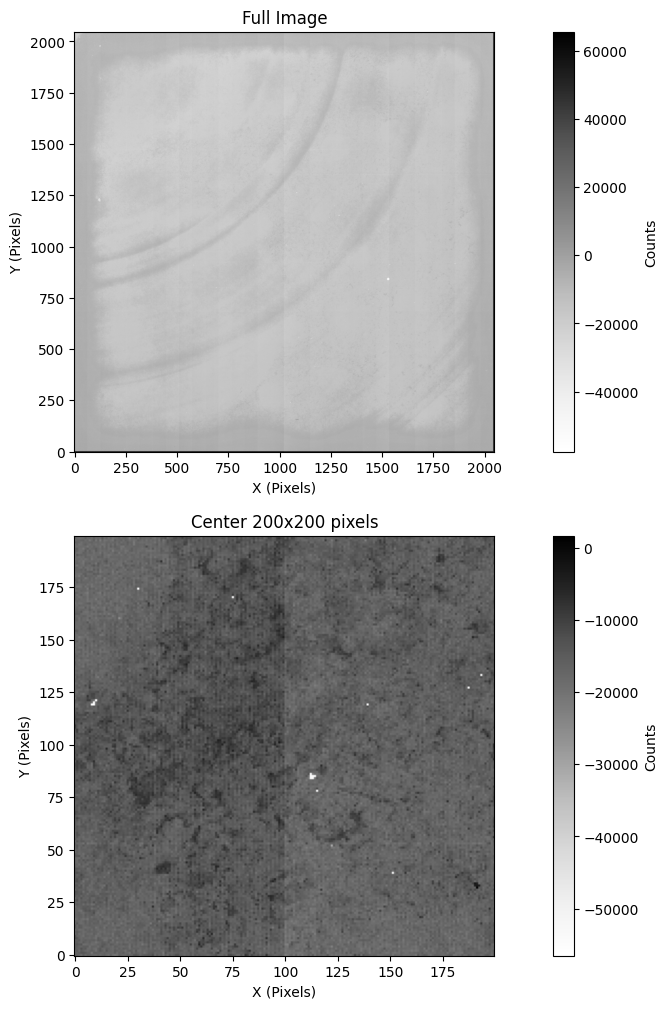

In [20]:


fig, axs = plt.subplots(2, 1, figsize = (15,12))

# Full Image
im1 = axs[0].imshow(curr_frame, cmap = 'Greys', origin = 'lower')
axs[0].set_title('Full Image')
axs[0].set_xlabel('X (Pixels)')
axs[0].set_ylabel('Y (Pixels)')
plt.colorbar(im1, ax = axs[0], label = 'Counts')

# Zoomed image
center_y, center_x = curr_frame.shape[0]//2, curr_frame.shape[1]//2
zoom_size = 100
zoomed = curr_frame[center_y-zoom_size:center_y+zoom_size, 
                    center_x-zoom_size:center_x+zoom_size]
im2 = axs[1].imshow(zoomed, cmap = 'Greys', origin = 'lower')
axs[1].set_title(f'Center {zoom_size*2}x{zoom_size*2} pixels')
plt.colorbar(im2, ax=axs[1], label='Counts')
axs[1].set_xlabel('X (Pixels)')
axs[1].set_ylabel('Y (Pixels)')

plt.show()

Frm_E0001_N00050.tif


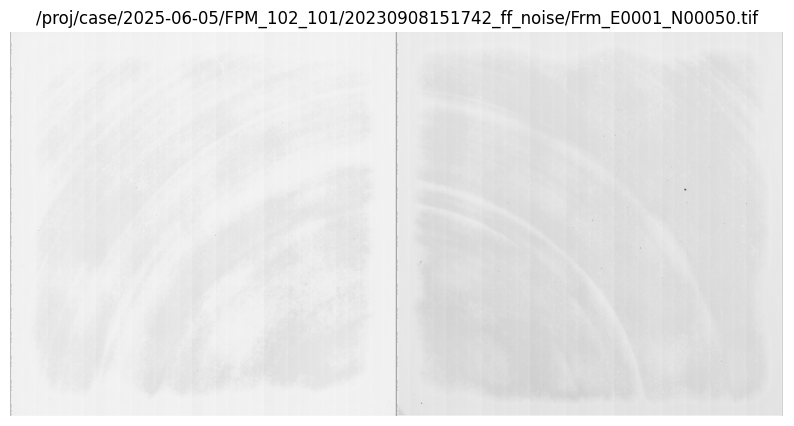

<tifffile.TiffTag 305 @16908430> coercing invalid ASCII to bytes, due to UnicodeDecodeError('charmap', b'Matrox Imaging Library [10.00]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x


(2048, 2048)


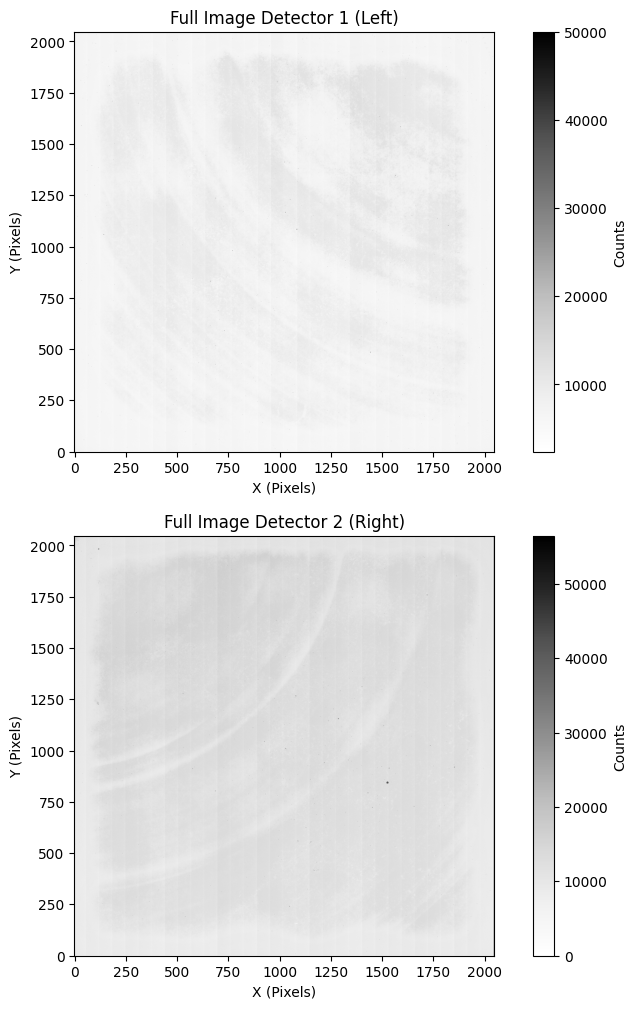

In [24]:
# Grab all case filenames
for dir in CASE_DIRS:
    path = f'{DATA_ROOT_DIR}/{dir}'
    path = f'{path}/{os.listdir(path)[0]}'

    filenames = training._grab_filenames(path)

    for i, filename in enumerate(filenames):
        print(filename)

        img = Image.open(f'{path}/{filename}')
        plt.figure(figsize=(10, 8))
        plt.imshow(img, cmap = 'Greys')
        plt.axis('off')  # Hide axes
        plt.title(f'{path}/{filename}')
        plt.show()

        tif_data = tifffile.imread(f'{path}/{filename}')

        # Split the data
        split_index = tif_data.shape[1] // 2

        detector_1 = tif_data[:, :split_index]
        detector_2 = tif_data[:, split_index:]

        # Take out the extra 8 columns on both sides
        detector_1 = detector_1[:, 8:-8]
        detector_2 = detector_2[:, 8:-8]

        print(detector_1.shape)

        assert detector_1.shape == (2048, 2048) and detector_2.shape == (2048, 2048)

        # Plot the two detectors
        fig, axs = plt.subplots(2, 1, figsize = (10,12))

        # Detector 1
        im1 = axs[0].imshow(detector_1, cmap = 'Greys', origin = 'lower')
        axs[0].set_title('Full Image Detector 1 (Left)')
        axs[0].set_xlabel('X (Pixels)')
        axs[0].set_ylabel('Y (Pixels)')
        plt.colorbar(im1, ax = axs[0], label = 'Counts')

        # Detector 3
        im1 = axs[1].imshow(detector_2, cmap = 'Greys', origin = 'lower')
        axs[1].set_title('Full Image Detector 2 (Right)')
        axs[1].set_xlabel('X (Pixels)')
        axs[1].set_ylabel('Y (Pixels)')
        plt.colorbar(im1, ax = axs[1], label = 'Counts')

        break

    break

In [23]:
d1_frame0, detector_1_difs, d2_frame_0, detector_2_difs

(array([[6332., 5959., 6389., ..., 4827., 6288., 5031.],
        [6272., 5233., 6494., ..., 4831., 5377., 4777.],
        [6340., 4970., 6832., ..., 4749., 5336., 4308.],
        ...,
        [5579., 4797., 5857., ..., 4529., 5329., 3770.],
        [6191., 4827., 6078., ..., 4645., 5113., 3862.],
        [6299., 4632., 6128., ..., 4484., 5224., 4395.]],
       shape=(2048, 2048)),
 [array([[36., 35., 40., ..., 18., 10.,  7.],
         [48., 34., 43., ..., 19., 16., 17.],
         [37., 39., 24., ..., 13.,  2.,  4.],
         ...,
         [45., 32., 42., ..., 23., 13., 17.],
         [33., 31., 23., ..., -2., 12., 11.],
         [54., 38., 40., ..., 11.,  9., 17.]], shape=(2048, 2048))],
 array([[7404., 7396., 7356., ...,    0.,    0.,    0.],
        [6167., 6589., 7489., ...,    0.,    0.,    0.],
        [7030., 6807., 6623., ...,    0.,    0.,    0.],
        ...,
        [6813., 6238., 7180., ...,    0.,    0.,    0.],
        [7024., 6742., 6002., ...,    0.,    0.,    0.],
     

NameError: name 'frame_difs' is not defined

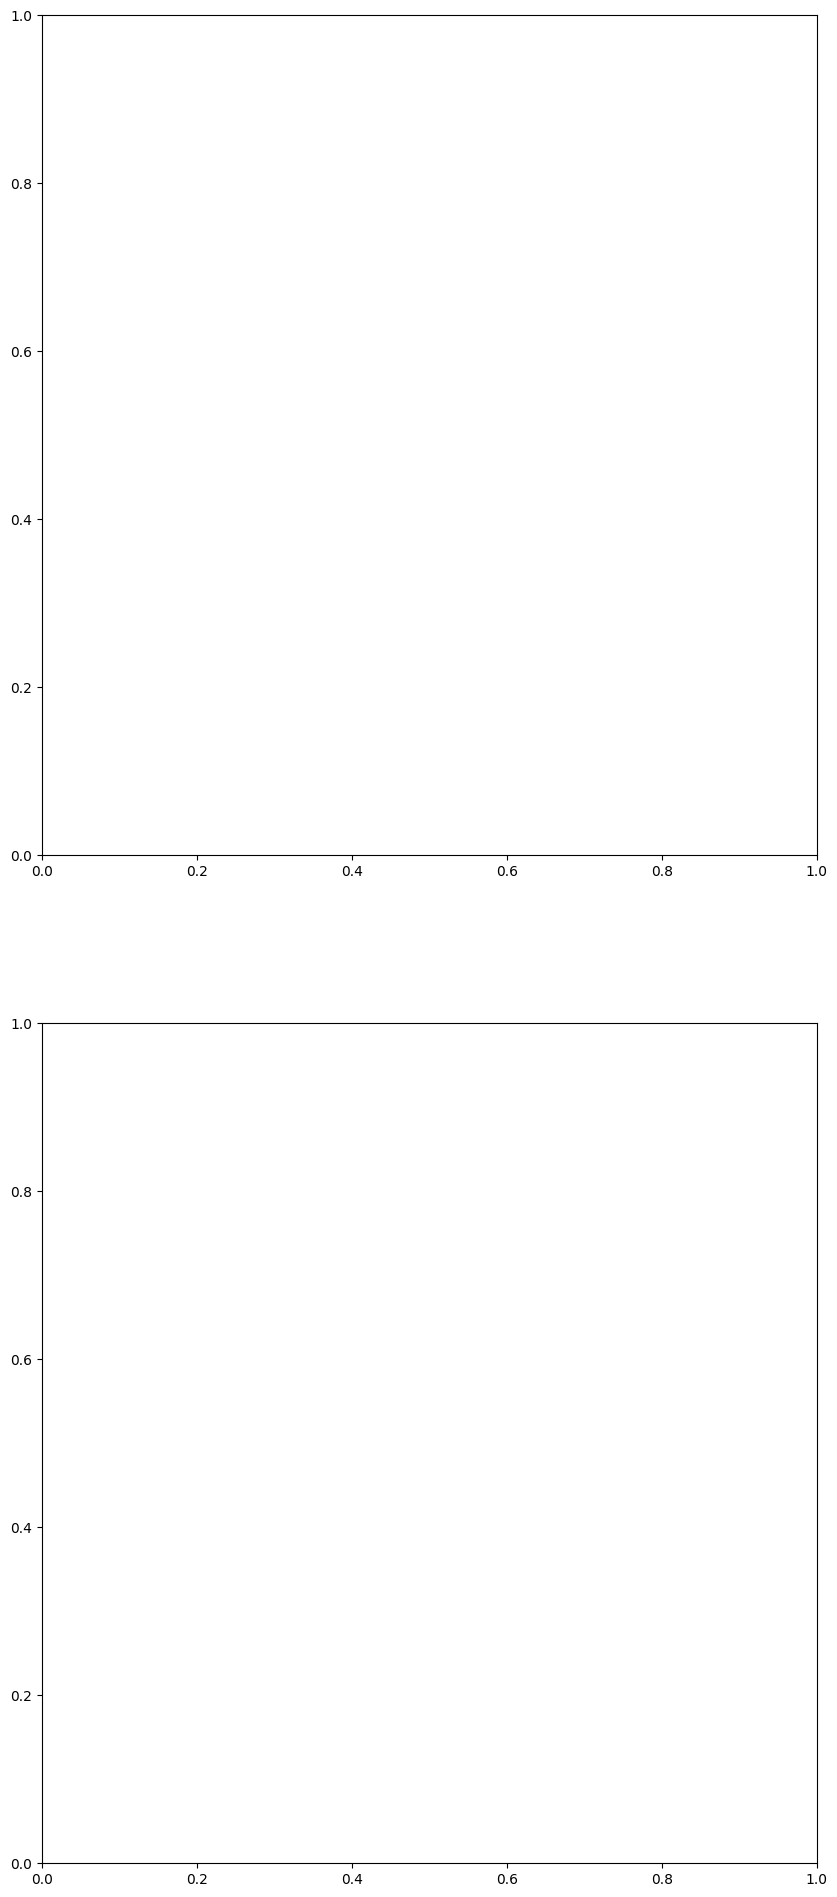

In [ ]:
fig, axs = plt.subplots(4, 1, figsize = (10,24))
    

frame_dif = frame_difs[0]

# Plot frame with log scale - add small value to avoid log(0)
frame_dif_log = frame_dif + 1  # Add 1 to avoid log(0)
im = axs[0].imshow(frame_dif_log, cmap='Greys', origin='lower', 
                    norm=LogNorm(vmin=1, vmax=frame_dif_log.max()))
axs[0].set_xlabel('X (Pixels)', size=12)
axs[0].set_ylabel('Y (Pixels)', size=12)
plt.colorbar(im, ax=axs[0], label='Counts (log scale)')

# Plot histogram of counts (already log scale)
axs[1].hist(frame_dif.flatten(), bins=200, alpha=0.7, edgecolor='black', color='grey')
axs[1].set_xlabel('Pixel Value', size=12)
axs[1].set_ylabel('Frequency', size=12)
axs[1].set_title('Histogram of Pixel Values', size=14)
axs[1].set_yscale('log')

im1 = axs[2].imshow(curr_frame, cmap = 'Greys', origin = 'lower')
axs[2].set_title('Full Image')
axs[2].set_xlabel('X (Pixels)')
axs[2].set_ylabel('Y (Pixels)')
plt.colorbar(im1, ax = axs[0], label = 'Counts')



plt.show()

In [ ]:
def make_movie(data, save_path, fps):
    """

    """
    # Set up first data plot first to avoid errors
    fig, ax = plt.subplots(figsize=(8, 6))
    data_log = data + 1
    im = ax.imshow(data_log[0], cmap='Greys', origin='lower', 
                       norm=LogNorm(vmin=1, vmax=data_log.max()))
    ax.set_xlabel('X (Pixels)', size=12)
    ax.set_ylabel('Y (Pixels)', size=12)
    
    # Create colorbar once
    cbar = plt.colorbar(im, ax=ax, label='Counts (Log Scale)')
    title = ax.set_title(f'Frame: 0/{len(data)}')
    fig.suptitle(f'Euclid Data: {save_path[7:-10]}', fontsize=14, fontweight='bold')
    
    def animate(i):
        im.set_array(data[i])
        title.set_text(f'Frame: {i}/{len(data)}')
        return [im, title]
    
    # Create animation instance
    ani = animation.FuncAnimation(fig, animate, frames=len(data), 
                                 interval=1000//fps, blit=True, repeat=True)
    
    # Save the animation
    if save_path.endswith('.gif'):
        ani.save(save_path, writer='Pillow', fps=fps)
    elif save_path.endswith('.mp4'):
        ani.save(save_path, writer='ffmpeg', fps=fps)
    else:
        print(f"Unsupported file format: {save_path}")
        return
        
    plt.close()
    
    print(f"Movie saved to: {save_path}")

In [ ]:
make_movie(frame_difs, 'ref_sub_movie.gif', 5)

In [ ]:
for i, frame_dif in enumerate(frame_difs):
    fig, axs = plt.subplots(2, 1, figsize=(15, 20))

    # Plot frame with log scale - add small value to avoid log(0)
    frame_dif_log = frame_dif + 1  # Add 1 to avoid log(0)
    im = axs[0].imshow(frame_dif_log, cmap='Greys', origin='lower', 
                       norm=LogNorm(vmin=1, vmax=frame_dif_log.max()))
    axs[0].set_xlabel('X (Pixels)', size=12)
    axs[0].set_ylabel('Y (Pixels)', size=12)
    plt.colorbar(im, ax=axs[0], label='Counts (log scale)')

    # Plot histogram of counts (already log scale)
    axs[1].hist(frame_dif.flatten(), bins=200, alpha=0.7, edgecolor='black', color='grey')
    axs[1].set_xlabel('Pixel Value', size=12)
    axs[1].set_ylabel('Frequency', size=12)
    axs[1].set_title('Histogram of Pixel Values', size=14)
    axs[1].set_yscale('log')

    plt.suptitle(f'Plots for subtracting 0th frame {i}', size=16, fontweight='bold')
    plt.show()

    if i == 10:

        break